In [1]:
from rcnn_utils import *
from torch.nn import init
from torchvision.transforms import v2

## Datasets

|Dataset|Type|Model|DICE train|DICE val|Params|
|-|-|-|-|-|-|
|RP500|Plain, Rectangle|RCNN-cell|.358 |.437|898|
|||LSTM-cell|.541|.546|2096|
|||RNN-cell (deeper)|.68|.70||
|||RNN-cell (SegNetDrop)|.46|.41||
|RP1000|Plain, Rectangle||
|RT500|Texture, Rectangle||
|RT1000|Texture, Rectangle||
|PP500|Plain, Polgon|RCNN-cell|.53|.53|898|
|||LSTM-cell|.53|.53|2096|
|||RSegNet-cell|1.977|1.978|~900k|
|PP1000|Plain, Polygon||
|PT500|Texture, Polygon|RNN-cell|1.97|1.98|898|
|||LSTM-cell|||2096|
|PT1000|Texture, Polygon||

In [2]:
def load_and_split(loader: Dataset, split: list, seed: torch.Generator) -> Data:
    return Data(*random_split(
        loader,
        split,
        seed
    )[:3])

In [3]:
# datasets 
dRP500 = load_and_split(
    BaseRcnnDataset("../data/DRect_plain_1000/data/", "../data/DRect_plain_1000/RCNNAnnotations/"),
    [400, 50, 50, 500],
    torch.Generator().manual_seed(10)
    )

dRP1000 = load_and_split(
    BaseRcnnDataset("../data/DRect_plain_1000/data/", "../data/DRect_plain_1000/RCNNAnnotations/"),
    [800, 100, 100],
    torch.Generator().manual_seed(10)
    )

dRT500 = load_and_split(
    BaseRcnnDataset("../data/DRect_texture_1000/data/", "../data/DRect_texture_1000/RCNNAnnotations/"),
    [400, 50, 50, 500],
    torch.Generator().manual_seed(10)
    )

dRT1000 = load_and_split(
    BaseRcnnDataset("../data/DRect_texture_1000/data/", "../data/DRect_texture_1000/RCNNAnnotations/"),
    [800, 100, 100],
    torch.Generator().manual_seed(10)
    )

dPP500 = load_and_split(
    BaseRcnnDataset("../data/DPoly_plain_1000/data/", "../data/DPoly_plain_1000/RCNNAnnotations/"),
    [400, 50, 50, 500],
    torch.Generator().manual_seed(10)
    )

dPP1000 = load_and_split(
    BaseRcnnDataset("../data/DPoly_plain_1000/data/", "../data/DPoly_plain_1000/RCNNAnnotations/"),
    [800, 100, 100],
    torch.Generator().manual_seed(10)
    )

dPT500 = load_and_split(
    BaseRcnnDataset("../data/DPoly_texture_1000/data/", "../data/DPoly_texture_1000/RCNNAnnotations/"),
    [400, 50, 50, 500],
    torch.Generator().manual_seed(10)
    )

dPT1000 = load_and_split(
    BaseRcnnDataset("../data/DPoly_texture_1000/data/", "../data/DPoly_texture_1000/RCNNAnnotations/"),
    [800, 100, 100],
    torch.Generator().manual_seed(10)
    )

## Models

1. RCNN cell
2. RCNN cell group
3. LSTM-CNN cell
4. LSTM-CNN cell group
5. ?GRU-CNN cell group (with pooling and unpooling and skip layers)

In [4]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
    def grad_norm(self):
        total_norm = 0.0
        for param in self.parameters():
            if param.grad is not None:
                param_norm = param.grad.data.norm(2)
                total_norm += param_norm.item() ** 2

        return total_norm

### RCNN cell

In [5]:
class UnitProcess(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.process = nn.Sequential(
          nn.Conv2d(in_channels, in_channels, 5, 1, 2),
          nn.BatchNorm2d(in_channels),
          nn.ReLU(),
          nn.Conv2d(in_channels, out_channels, 3, 1, 1),
        )
        
        init.orthogonal_(self.process[0].weight)
        init.orthogonal_(self.process[-1].weight)
        
    def forward(self, x):
        return self.process(x)
    
class UnitProcess2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.process = nn.Sequential(
          nn.Conv2d(in_channels, in_channels, 5, 1, 2),
          nn.BatchNorm2d(in_channels),
          nn.ReLU(),
          nn.Conv2d(in_channels, in_channels*2, 5, 1, 2),
          nn.BatchNorm2d(in_channels*2),
          nn.ReLU(),
          nn.Conv2d(in_channels*2, in_channels*4, 5, 1, 2),
          nn.BatchNorm2d(in_channels*4),
          nn.ReLU(),
          nn.Conv2d(in_channels*4, in_channels*2, 5, 1, 2),
          nn.BatchNorm2d(in_channels*2),
          nn.ReLU(),
          nn.Conv2d(in_channels*2, in_channels, 5, 1, 2),
          nn.BatchNorm2d(in_channels),
          nn.ReLU(),
          nn.Conv2d(in_channels, out_channels, 3, 1, 1),
        )
        
    def forward(self, x):
        return self.process(x)
    

class RCNNCell(Model):
    def __init__(self, in_channels, height, width, UnitProcess=UnitProcess, out_channels=1):
        super().__init__()

        self.in_channels = in_channels
        self.height = height
        self.width = width
        self.out_channels = out_channels

        # hidden state
        # self.hidden = torch.randn(in_channels, height, width)
        self.register_buffer('hidden', torch.ones(1, in_channels, height, width))
        self.hidden = self.hidden.to("cuda")
        
        # output generation
        self.Wya = UnitProcess(in_channels, out_channels).to("cuda")
        
        # hidden state processing  
        self.Waa = UnitProcess(in_channels, in_channels).to("cuda")
        self.Wax = UnitProcess(in_channels, in_channels).to("cuda")
                
    def forward(self, x):
        # calculate state
        hidden_batched = self.hidden.expand(x.shape[0], -1, -1, -1)  
        # hidden_batched = self.hidden
        
        self.hidden = nn.functional.relu(self.Waa(hidden_batched) + self.Wax(x))
       
        # calculate output
        x = nn.functional.relu(self.Wya(self.hidden))
        
        return x
    
    def resetState(self):
        self.hidden = torch.ones(1, self.in_channels, self.height, self.width).to("cuda")

### RCNN

In [6]:
class RCNN(Model):
    def __init__(self, rcnn_cell, n_cells, in_channels, height, width, out_channels=1):
        super().__init__()
        
        self.n_cells = n_cells
        self.in_channels = in_channels
        self.height = height
        self.width = width
        self.out_channels = 1
        
        self.rcnn_cells = nn.ModuleList()
        for i in range(n_cells):
            if i == 0:
                c = in_channels
            else:
                c = out_channels
            self.rcnn_cells.append(rcnn_cell(c, height, width, out_channels))


    def forward(self, x):
        """
        x: list of tokens (c, h, w)
        """
        # reset all cell states for new input
        for cell in self.rcnn_cells:
            cell.resetState()
        
        # keep feed layer output to next layer
        layer_input = x
        layer_output = []
        for i, cell in enumerate(self.rcnn_cells):
            # generating output for nth cell
            for input_t in layer_input:
                layer_output.append(cell(input_t))
                
            # output becomes input
            layer_input = layer_output
            if i+1 < len(self.rcnn_cells):
                layer_output = []
                
        return layer_output
    
    def resetState(self):
        return

### LSTM-CNN

In [7]:
class RLSTMCell(Model):
    def __init__(self, in_channels, height, width, out_channels=1, cell_unit = UnitProcess):
        super().__init__()

        self.in_channels = in_channels
        self.height = height
        self.width = width
        self.out_channels = out_channels

        # hidden and cell states
        # self.hidden = torch.randn(in_channels, height, width)
        self.register_buffer('hidden_state', torch.ones(1, in_channels, height, width))
        self.register_buffer('cell_state', torch.ones(1, in_channels, height, width))
        self.hidden_state = self.hidden_state.to("cuda")
        self.cell_state = self.cell_state.to("cuda")
        
        # forget gate
        self.Wf = cell_unit(in_channels, out_channels)
        self.Uf = cell_unit(in_channels, out_channels)
        
        # input gate
        self.Wi = cell_unit(in_channels, out_channels)
        self.Ui = cell_unit(in_channels, out_channels)
        
        # output gate
        self.Wo = cell_unit(in_channels, out_channels)
        self.Uo = cell_unit(in_channels, out_channels)
        
        # cell state
        self.Wc = cell_unit(in_channels, out_channels)
        self.Uc = cell_unit(in_channels, out_channels)
        
        # activations
        self.sig1 = nn.Tanh()
        self.sig2 = nn.Tanh()
        self.sig3 = nn.Tanh()
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
               
        
    def forward(self, x):
        # forget gate
        f_t = self.sig1(self.Wf(x) + self.Uf(self.hidden_state))
        
        # input gate
        i_t = self.sig2(self.Wi(x) + self.Ui(self.hidden_state))
        
        # output gate
        o_t = self.sig3(self.Wo(x) + self.Uo(self.hidden_state))
        
        # cell state
        c_t_prime =self.relu1(self.Wc(x) + self.Uc(self.hidden_state))
        self.cell_state = f_t * self.cell_state + i_t * c_t_prime
        
        # hidden state
        self.hidden_state = o_t * self.relu2(self.cell_state)
        
        return o_t
    
    def resetState(self):
        self.hidden_state = torch.ones(1, self.in_channels, self.height, self.width).to("cuda")
        self.cell_state = torch.ones(1, self.in_channels, self.height, self.width).to("cuda")

### LSTM-CNN Group

In [8]:
# Use RCNN class

### UNet

In [8]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False), # no bias for batch norm
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.conv(x)
    
class UNet(nn.Module):
    def __init__(
        self,
        in_channels=3, 
        out_channels=1,
        features=[64, 128, 256, 512],
        dropout=0.,
        DoubleConv = DoubleConv
    ):
        super().__init__()
        
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = dropout
        
        # downs
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
            
        # ups
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2,
                    feature,
                    2,
                    2
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))
            
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        
        self.final_conv = nn.Conv2d(features[0], out_channels, 1)
    
    def forward(self, x):
        skip_connections = []
        
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
            x = nn.functional.dropout2d(x, self.dropout)
            
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:], antialias=True)
            
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
            x = nn.functional.dropout2d(x, self.dropout)
            
        return self.final_conv(x)
    
    def grad_norm(self):
        total_norm = 0.0
        for param in self.parameters():
            if param.grad is not None:
                param_norm = param.grad.data.norm(2)
                total_norm += param_norm.item() ** 2

        return total_norm

# Experiments

Hyper parameters:
- Loss: BCE loss
- epochs 100

Outputs:
- Loss curves
- gradient sums
- dice score

## Utils

In [9]:
from torch.utils.tensorboard import SummaryWriter

In [ ]:
# train loop
# tensorboard logging
# model save
# train and validation metrics

In [10]:
def binary_dice_coefficient(prediction, target, threshold=0.5, smooth=1e-5):
    prediction_binary = (prediction > threshold).float()
    
    intersection = torch.sum(prediction_binary * target)
    union = torch.sum(prediction_binary) + torch.sum(target)

    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.cpu().detach()


def dice_score(model, dataset, threshold=0.5, device="cuda", norm=1):
    score_sum = 0
    count = 0
    with torch.inference_mode():
        for i, data in enumerate(dataset):
            input, target = data
            input, target = input.to(device), [torch.tensor(t).to(device) for t in target]
            
            model.resetState()
            
            prediction = model(input.unsqueeze(dim=0))
            
            for t in target:
                score_sum += float(binary_dice_coefficient(prediction.squeeze(), t/norm, threshold))
                prediction = model(input.unsqueeze(dim=0))
                count += 1
            
            print(f"{i:4d}/{len(dataset)}", end="\r")

    return score_sum/count


def dice_score_group(model, dataset, threshold=0.5, device="cuda"):
    score_sum = 0
    with torch.inference_mode():
        for i, data in enumerate(dataset):
            input, target = data
            input, target = [input.to(device).unsqueeze(dim=0) for _ in range(len(target))], [torch.tensor(t).to(device) for t in target]
            model.resetState()
            prediction = model(input)
                
            prediction = [torch.sigmoid(p) for p in prediction]
            score_sum += sum([binary_dice_coefficient(p.squeeze(), t, threshold) for p, t in zip(prediction, target)])
            print(f"{i:4d}/{len(dataset)}", end="\r")

    return score_sum/len(dataset)


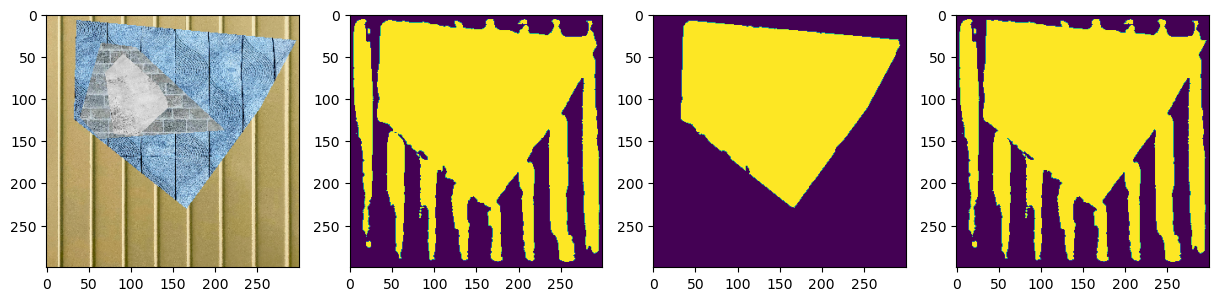

In [103]:
with torch.inference_mode():
    image, target = dPT500.train[9][0], dPT500.train[9][1][0]/255
    model.resetState()
    out = model(image.cuda().unsqueeze(dim=0))
    
    out = out.sigmoid().squeeze().detach().cpu().numpy()
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(image.permute(1, 2, 0))
    
    plt.subplot(1, 4, 2)
    out = out > 0.5
    plt.imshow(out)
    
    plt.subplot(1, 4, 3)
    plt.imshow(out * target)
    
    plt.subplot(1, 4, 4)
    plt.imshow((out + target) >= 1)
    
    

In [82]:
out.max(), out.min()

(1.0, 0.5)

In [11]:
def iou(prediction, target, threshold=0.5, smooth=1e-5, norm=1):
    prediction_binary = (prediction > threshold).float()
    
    target /= norm
    intersection = torch.sum(prediction_binary * target)
    union = prediction_binary + target
    union[union > 1] = 1
    union = torch.sum(union)

    dice = (intersection + smooth) / (union + smooth)
    return dice.cpu().detach()

def iou_score(model, dataset, threshold=0.5, device="cuda", norm=1):
    score_sum = 0
    count = 0
    with torch.inference_mode():
        for i, data in enumerate(dataset):
            input, target = data
            input, target = input.to(device), [torch.tensor(t).to(device) for t in target]
            model.resetState()
                
            prediction = model(input.unsqueeze(dim=0))
            
            for t in target:
                score_sum += float(iou(prediction.squeeze(), t/norm, threshold))
                prediction = model(input.unsqueeze(dim=0))
                count += 1
                
            print(f"{i:4d}/{len(dataset)}", end="\r")

    return score_sum/count


In [63]:
iou_score(model, dRP500.train)

Inter: 14247.0, union: 14408.0
Inter: 919.0, union: 2520.0
Inter: 344.0, union: 428.0
Inter: 0.0, union: 17.0
Inter: 11197.0, union: 12089.0
Inter: 924.0, union: 7862.0
Inter: 62.0, union: 483.0
Inter: 0.0, union: 0.0
Inter: 12257.0, union: 12584.0
Inter: 1844.0, union: 5916.0
Inter: 42.0, union: 1457.0
Inter: 0.0, union: 10.0


0.47032432096832616

In [12]:
def train(
    dataset: Data, 
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer, 
    loss: torch.nn.Module, 
    writer: SummaryWriter,
    n_epochs: tuple=(0, 50),
    device: str="cuda",
    dice: bool=False,
    norm: float=1.0):
    
    for epoch in range(*n_epochs):
        epoch_loss = 0
        for data in dataset.train:
            # reset hidden state
            model.resetState()
            
            image, annotation = data
            image = image.to(device).unsqueeze(dim=0)
            
            optimizer.zero_grad()
            
            output = model(image)
            
            l = 0
        
            for weight, ann in enumerate(annotation):
                ann = torch.tensor(ann).to("cuda").unsqueeze(dim=0).unsqueeze(dim=0).float()/norm
                l += loss(output, ann)
                # next step input                
                output = model(image)
            
            l.backward()
            
            optimizer.step()
        
            epoch_loss += float(l)
            
        epoch_loss /= len(dataset.train)
        writer.add_scalar("Loss/train", epoch_loss, epoch)
        print(f"Epoch {epoch}: {epoch_loss}")
            
        # val
        with torch.inference_mode():
            val_loss = 0
            for data in dataset.val:
                # reset hidden state
                model.resetState()
                
                image, annotation = data
                image = image.to(device).unsqueeze(dim=0)
                
                output = model(image)
                
                l = 0
            
                for weight, ann in enumerate(annotation):
                    ann = torch.tensor(ann).to("cuda").unsqueeze(dim=0).unsqueeze(dim=0).float()/norm
                    l += loss(output, ann)
                    # next step input                
                    output = model(image)
                    
                val_loss += float(l)
                
            val_loss /= len(dataset.val)
            writer.add_scalar("Loss/val", val_loss, epoch)
            writer.add_scalar("GradNorm", model.grad_norm(), epoch)
            
    if not dice:
        return
    for i, thresh in enumerate(np.arange(0, 1, 0.1)):
        writer.add_scalar("Dice/train", dice_score(model, dataset.train, thresh), i)
        writer.add_scalar("Dice/val", dice_score(model, dataset.val, thresh), i)
        
        writer.add_scalar("IoU/train", iou_score(model, dataset.train, thresh), i)
        writer.add_scalar("IoU/val", iou_score(model, dataset.val, thresh), i)
        

In [13]:
def train_group(dataset: Data, 
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer, 
    loss: torch.nn.Module, 
    writer: SummaryWriter,
    n_epochs: tuple=(0, 100),
    device: str="cuda",
    dice: bool=False):
    for epoch in range(*n_epochs):
        epoch_loss = 0
        # train
        model.train()
        for data in dataset.train:
            # reset hidden state
            model.resetState()
            
            image, annotation = data
            image = [image.to(device).unsqueeze(dim=0) for _ in range(len(annotation))]
        
            output = model(image)
            
            # compute loss
            l = 0
            for i, ann in enumerate(annotation):
                loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(float((i+1))).to("cuda"))
                ann = torch.tensor(ann).to(device).unsqueeze(dim=0).unsqueeze(dim=0)
                l += loss(output[i], ann) #* (weight+1)
                    
            l.backward()
            
            # clipping gradients
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
        
            epoch_loss += float(l)
            
        epoch_loss /= len(dataset.train)
        writer.add_scalar("Loss/train", epoch_loss, epoch)
        print(f"Epoch {epoch}: {epoch_loss}")
            
        # val
        model.eval()
        with torch.inference_mode():
            val_loss = 0
            for data in dataset.val:
                # reset hidden state
                model.resetState()
                
                image, annotation = data
                image = [image.to(device).unsqueeze(dim=0) for _ in range(len(annotation))]
                
                output = model(image)
            
            # compute loss
            l = 0
            for i, ann in enumerate(annotation):
                loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(float((i+1))).to("cuda"))
                ann = torch.tensor(ann).to(device).unsqueeze(dim=0).unsqueeze(dim=0)
                l += loss(output[i], ann) #* (weight+1)
                    
                val_loss += float(l)
                
            val_loss /= len(dataset.val)
            writer.add_scalar("Loss/val", val_loss, epoch)
            writer.add_scalar("GradNorm", model.grad_norm(), epoch)
            
    if not dice:
        return
    for i, thresh in enumerate(np.arange(0, 1, 0.1)):
        writer.add_scalar("Dice/train", dice_score_group(model, dataset.train, thresh), i)
        writer.add_scalar("Dice/val", dice_score_group(model, dataset.val, thresh), i)

In [14]:
import matplotlib.pyplot as plt

def show_results(model, dataset, idx, in_channels=3, height=200, width=200):
    with torch.inference_mode():
        image, annotation = dataset[idx]
        plt.figure(figsize=(20, 10))
        
        plt.subplot(1, 7, 1)
        plt.imshow(image.permute(1,2,0))
        plt.axis("off")
        
        image = (image).unsqueeze(dim=0).to("cuda")
        
        model.hidden = torch.ones(1, in_channels, height, width).to("cuda")
        for i in range(5):
            plt.subplot(1, 7, i+2)
            output = model(image)
            
            plt.imshow(output.detach().cpu().squeeze())
            # plt.imshow(annotation[i])
            plt.axis("off")
            
            
def show_results_group(model, dataset, idx, in_channels=3, height=200, width=200):
    with torch.inference_mode():
        image, annotation = dataset[idx]
        plt.figure(figsize=(20, 10))
        
        plt.subplot(1, 7, 1)
        plt.imshow(image.permute(1,2,0))
        plt.axis("off")
        
        image = [image.cuda().unsqueeze(dim=0) for _ in range(5)]
        output = model(image)
        
        for i in range(5):
            plt.subplot(1, 7, i+2)
            
            plt.imshow(output[i].detach().cpu().squeeze())
            # plt.imshow(annotation[i])
            plt.axis("off")

In [15]:
def n_params(model):
    return sum(param.numel() for param in model.parameters() if param.requires_grad)

## RP500

### Exp - RP500, R-CNN

In [34]:
model = RCNNCell(3, 200, 200).to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(4.).cuda())
writer = SummaryWriter(f"./runs2/RP500_RCNN", comment="BCE_pos=4.0")

In [40]:
train(dRP500,
      model,
      optimizer,
      loss,
      writer,
      n_epochs=(100, 100),
      dice=True)

Epoch 50: 2.8658052426576615
Epoch 51: 2.8648967391252516
Epoch 52: 2.8643651711940765
Epoch 53: 2.863692690730095
Epoch 54: 2.8633517163991926
Epoch 55: 2.8620171386003492
Epoch 56: 2.86283601462841
Epoch 57: 2.8615716928243637
Epoch 58: 2.8605193799734114
Epoch 59: 2.8599308663606644
Epoch 60: 2.8592817008495333
Epoch 61: 2.8593926107883454
Epoch 62: 2.8587773489952086
Epoch 63: 2.8580124789476393
Epoch 64: 2.8572924721240995
Epoch 65: 2.8573592579364777
Epoch 66: 2.856669044494629
Epoch 67: 2.8567984926700594
Epoch 68: 2.8551044982671736
Epoch 69: 2.855049113035202
Epoch 70: 2.8567630714178085
Epoch 71: 2.8526697832345964
Epoch 72: 2.8533795821666716
Epoch 73: 2.853014947772026
Epoch 74: 2.8522373628616333
Epoch 75: 2.851635656952858
Epoch 76: 2.8513557821512223
Epoch 77: 2.8505069184303284
Epoch 78: 2.8502421736717225
Epoch 79: 2.851025225520134
Epoch 80: 2.8499586391448974
Epoch 81: 2.849120099544525
Epoch 82: 2.849478151202202
Epoch 83: 2.8481751781702043
Epoch 84: 2.849610296487

In [50]:
n_params(model)

898

In [64]:
torch.save(model, "./models/RP500_RCNN_1.pth")
# model = torch.load("./models/RP500_RCNN.pth")

In [28]:
def get_iou(model, dataset, norm=1):
    print(f"T    {'IoU':8s}, {'IoU':8s}, {'DICE':8s}, {'DICE':8s}")
    for i in np.arange(0, 1.1, 0.1):
        print(f"{i:0.2f}: {float(iou_score(model, dataset.train, i, norm=norm)):0.6f}, {float(iou_score(model, dataset.val, i, norm=norm)):0.6f}, {float(dice_score(model, dataset.train, i, norm=norm)):0.6f}, {dice_score(model, dataset.val, i, norm=norm):0.6f}")
        # print(f"{i:0.2f} DICE: ")
        
        
# get_iou(model, dRP500)

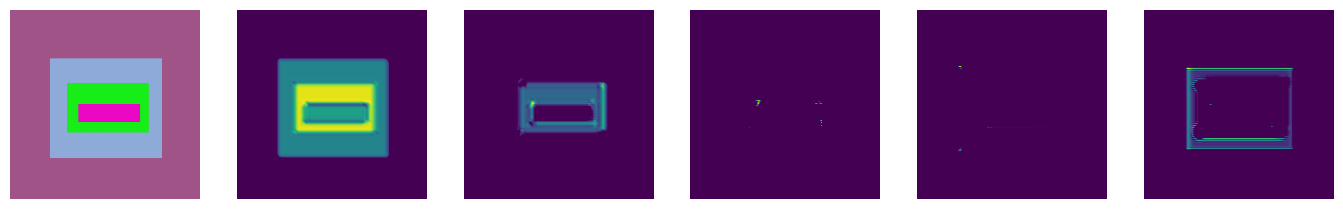

In [44]:
show_results(model, dRP500.val, 2)

T    IoU     , IoU     , DICE    , DICE    
0.00: 0.504090, 0.501957, 0.556533, 0.549107
0.10: 0.520896, 0.511104, 0.572644, 0.557927
0.20: 0.538590, 0.520860, 0.589946, 0.567427
0.30: 0.552567, 0.550735, 0.603765, 0.597794
0.40: 0.563588, 0.554821, 0.614395, 0.602000
0.50: 0.570539, 0.569389, 0.620921, 0.617028
0.60: 0.577585, 0.572454, 0.627539, 0.620281
0.70: 0.578024, 0.574922, 0.627493, 0.622620
0.80: 0.579854, 0.576786, 0.628928, 0.624285
0.90: 0.580857, 0.574275, 0.629418, 0.621315
1.00: 0.580601, 0.582445, 0.628766, 0.629216

### Exp - RP500, LSTM-CNN

In [69]:
model = RLSTMCell(3, 200, 200).to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(4.).cuda())
writer = SummaryWriter(f"./runs2/RP500_LSTM", comment="Lr_1e-5, BCE=4.")
n_params(model)

2096

In [70]:
train(dRP500,
      model,
      optimizer,
      loss,
      writer,
      n_epochs=(100,100),
      dice=True)

Epoch 0: 3.5677882128953935
Epoch 1: 2.9732677334547044
Epoch 2: 2.818044718205929
Epoch 3: 2.7315074226260183
Epoch 4: 2.661678736805916
Epoch 5: 2.58903030693531
Epoch 6: 2.5182815766334534
Epoch 7: 2.4723845142126084
Epoch 8: 2.4179670959711075
Epoch 9: 2.377279736995697
Epoch 10: 2.3574600914120674
Epoch 11: 2.3432443091273307
Epoch 12: 2.3236496478319166
Epoch 13: 2.3077498683333397
Epoch 14: 2.2971707037091256
Epoch 15: 2.2827412021160125
Epoch 16: 2.2737061470746993
Epoch 17: 2.2574551379680634
Epoch 18: 2.2480329117178917
Epoch 19: 2.2391017723083495
Epoch 20: 2.2315057745575904
Epoch 21: 2.2238275891542436
Epoch 22: 2.2139469090104105
Epoch 23: 2.207404509484768
Epoch 24: 2.2006445321440697
Epoch 25: 2.197662082016468
Epoch 26: 2.1915992850065233
Epoch 27: 2.1925442779064177
Epoch 28: 2.186390508413315
Epoch 29: 2.1829922080039976
Epoch 30: 2.1791133296489718
Epoch 31: 2.1739878341555596
Epoch 32: 2.1676400473713873
Epoch 33: 2.165002702176571
Epoch 34: 2.1604676863551138
Epoc

In [82]:
torch.save(model, "./models/RP500_LSTM_1.pth")
# model = torch.load("./models/RP500_RNN_CNN_deep.pth")

In [72]:
get_iou(model, dRP500)

T    IoU     , IoU     , DICE    , DICE    
0.00: 0.357109, 0.360876, 0.407357, 0.414594
0.10: 0.359373, 0.358066, 0.408793, 0.411152
0.20: 0.361973, 0.358349, 0.411048, 0.410260
0.30: 0.362272, 0.359352, 0.410968, 0.411557
0.40: 0.359918, 0.364360, 0.408237, 0.416593
0.50: 0.355667, 0.360144, 0.403875, 0.412721
0.60: 0.356825, 0.355659, 0.405123, 0.408802
0.70: 0.354905, 0.357276, 0.403017, 0.410461
0.80: 0.347537, 0.353781, 0.395530, 0.407996
0.90: 0.343453, 0.341044, 0.391043, 0.395448
1.00: 0.250000, 0.250000, 0.250000, 0.250000


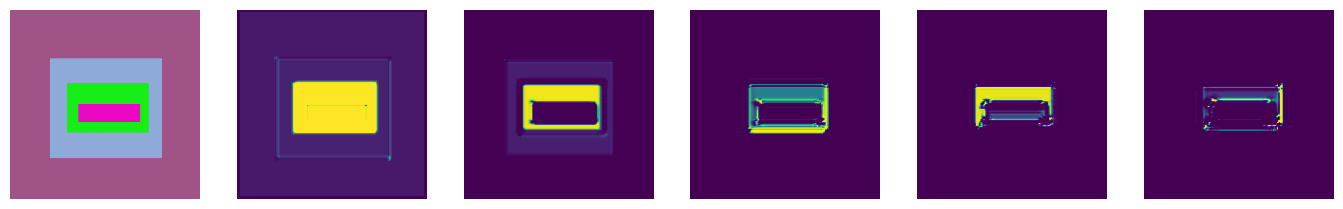

In [81]:
model.resetState()
show_results(model, dRP500.val, 2)

### Exp - RP500, RCNN group

In [41]:
model =  RCNN(rcnn_cell=lambda *x: RCNNCell(*x),
             n_cells=2,
             in_channels=3,
             height=200,
             width=200,
             out_channels=1).to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(4.).cuda())
writer = SummaryWriter(f"./runs/RP500_RCNN_Group_ortho", comment="BCE=4.0,lr=1e-4,cells=2,ortho_init")
n_params(model)

1012

In [35]:
train_group(dRP500,
      model,
      optimizer,
      loss,
      writer,
      n_epochs=(0, 10)
      )

Epoch 0: 2.8564747847130705
Epoch 1: 2.8512153672517377
Epoch 2: 2.851197821872854
Epoch 3: 2.8511979019962244
Epoch 4: 2.8511979019962244
Epoch 5: 2.8511979019962244
Epoch 6: 2.8511979019962244
Epoch 7: 2.8511979019962244
Epoch 8: 2.8511979019962244
Epoch 9: 2.8511979019962244


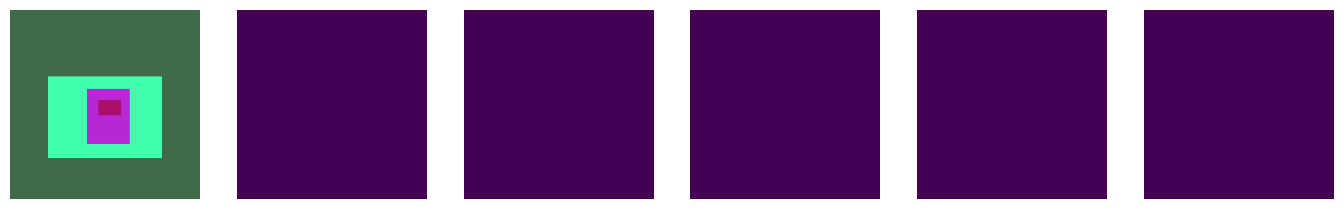

In [21]:
show_results_group(model, dRP500.train, 4)

Can't train

### Exp - RP500, LSTM-CNN group

In [45]:
model = RCNN(rcnn_cell=lambda *x: RLSTMCell(*x),
             n_cells=2,
             in_channels=3,
             height=200,
             width=200,
             out_channels=1).to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(4.).cuda())
writer = SummaryWriter(f"./runs/RP500_LSTM_Group_ortho_clip", comment="BCE=4.0,lr=1e-4,cells=4 ortho init with clipping")
n_params(model)

2400

In [46]:
train_group(dRP500,
      model,
      optimizer,
      loss,
      writer,
      n_epochs=(0, 10)
      )

Epoch 0: 2.610196255184271
Epoch 1: 2.115631342119953
Epoch 2: 1.9034070779793755
Epoch 3: 1.7822841977964656
Epoch 4: 1.7239764015065087
Epoch 5: 1.6982625248459415
Epoch 6: 1.674251758210587
Epoch 7: 1.647503039968345
Epoch 8: 1.632618001268118
Epoch 9: 1.6189249484878911


Exploding gradient, clipping doesn't work

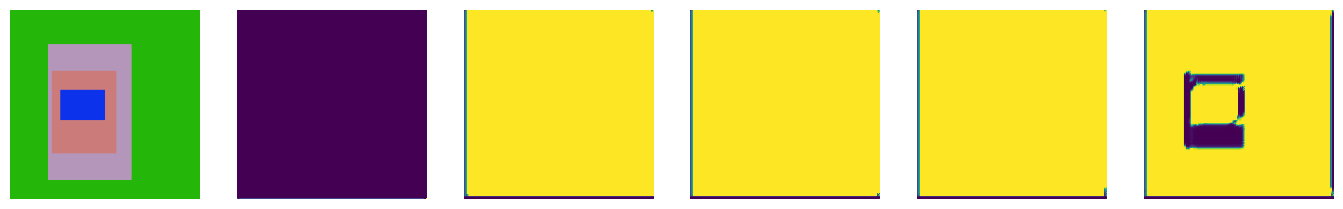

In [47]:
show_results_group(model, dRP500.train, 2)

### Exp - RP500, SegNet implementation

In [34]:
SegNet = lambda x, y: nn.Sequential(
    nn.Conv2d(x, 64, 3, 1, 1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(64, 128, 3, 1, 1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Dropout(0.05),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(128, 128, 3, 1, 1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Dropout(0.05),
    
    nn.ConvTranspose2d(128, 64, 2, 2),
    nn.Conv2d(64, 64, 3, 1, 1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    
    nn.ConvTranspose2d(64, 32, 2, 2),
    nn.Conv2d(32, 32, 3, 1, 1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, y, 3, 1, 1),
    
)

In [97]:
model = RLSTMCell(3, 200, 200, cell_unit=SegNet).to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(4.).cuda())
writer = SummaryWriter(f"./runs2/RP500_LSMT_SegNet", comment="BCE_pos=4.0, segnet, lr=1e-4, dropout")
n_params(model)

2492680

In [98]:
train(dRP500,
      model,
      optimizer,
      loss,
      writer,
      n_epochs=(0, 100),
      dice=True
      )

Epoch 0: 2.874565827846527
Epoch 1: 2.219183562994003
Epoch 2: 2.022545528113842
Epoch 3: 1.9213485518097877
Epoch 4: 1.859939804673195
Epoch 5: 1.8125971767306328
Epoch 6: 1.7765031453967095
Epoch 7: 1.7496068239212037
Epoch 8: 1.7279907771945
Epoch 9: 1.7082529756426812
Epoch 10: 1.6913290986418723
Epoch 11: 1.6771346673369407
Epoch 12: 1.6660704588890076
Epoch 13: 1.656706342101097
Epoch 14: 1.6493619871139527
Epoch 15: 1.6436321103572846
Epoch 16: 1.6378962248563766
Epoch 17: 1.6346040922403335
Epoch 18: 1.6395296904444694
Epoch 19: 1.6347671097517014
Epoch 20: 1.626952013373375
Epoch 21: 1.6234242770075797
Epoch 22: 1.6201624375581742
Epoch 23: 1.6172050872445107
Epoch 24: 1.6153711819648742
Epoch 25: 1.6135186889767648
Epoch 26: 1.614784278869629
Epoch 27: 1.6125306609272956
Epoch 28: 1.611943966150284
Epoch 29: 1.612077267765999
Epoch 30: 1.6064592644572258
Epoch 31: 1.6057245227694512
Epoch 32: 1.6077004179358483
Epoch 33: 1.611656621694565
Epoch 34: 1.6072809219360351
Epoch 35

KeyboardInterrupt: 

In [94]:
torch.save(model, "./models/RP500_LSMTSegNet_1.pth")
# model = torch.load("./models/RP500_RSegNet_1.pth")

In [102]:
get_iou(model, dRP500)

T    IoU     , IoU     , DICE    , DICE    
0.00: 0.950248, 0.817700, 0.972180, 0.858359
0.10: 0.953090, 0.808328, 0.972288, 0.857653
0.20: 0.951311, 0.821596, 0.973778, 0.852939
0.30: 0.955582, 0.815105, 0.972247, 0.863799
0.40: 0.955218, 0.815612, 0.973919, 0.856732
0.50: 0.955389, 0.822757, 0.973936, 0.867944
0.60: 0.955563, 0.819510, 0.975481, 0.869325
0.70: 0.957786, 0.818950, 0.976456, 0.875005
0.80: 0.957861, 0.824869, 0.975617, 0.866445
0.90: 0.957878, 0.824803, 0.975644, 0.870624
1.00: 0.250000, 0.250000, 0.250000, 0.250000


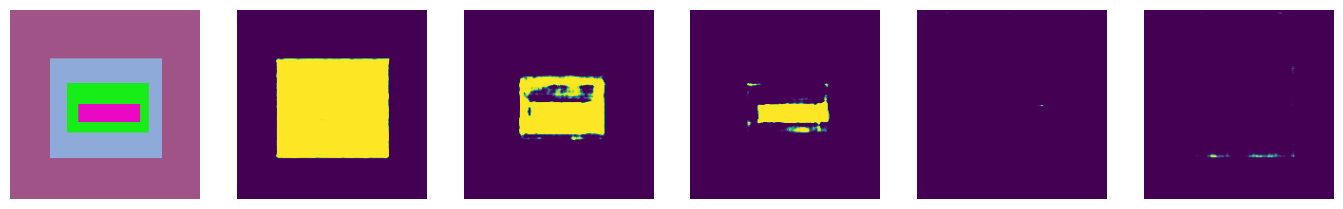

In [101]:
model.resetState()
show_results(model, dRP500.val, 2)

### Exp - RP500, RCNN-UNet

In [24]:
model = RCNNCell(3, 200, 200, UnitProcess=lambda x,y: UNet(x, y, [16, 32, 64])).to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(4.).cuda())
writer = SummaryWriter(f"./runs2/RP500_RCNN_UNet", comment="BCE_pos=4.0")
n_params(model)

1448279

In [34]:
train(dRP500,
      model,
      optimizer,
      loss,
      writer,
      n_epochs=(20, 50)
      )

Epoch 20: 2.561030784845352
Epoch 21: 2.5567917853593825
Epoch 22: 2.550221564769745
Epoch 23: 2.5458530586957933
Epoch 24: 2.543606609106064
Epoch 25: 2.542794861197472
Epoch 26: 2.609542968273163
Epoch 27: 2.6138193464279174
Epoch 28: 2.566350325345993
Epoch 29: 2.5557285177707674
Epoch 30: 2.54803250849247


KeyboardInterrupt: 

In [32]:
torch.save(model, "./models/RP500_RNNUNet_s.pth")
# model = torch.load("./models/RP500_RSegNet_1.pth")

In [36]:
get_iou(model, dRP500)

T    IoU     , IoU     , DICE    , DICE    
0.00: 0.776846, 0.737370, 0.798431, 0.764673
0.10: 0.917414, 0.902143, 0.936847, 0.928155
0.20: 0.945163, 0.922924, 0.963804, 0.948610
0.30: 0.951208, 0.928287, 0.969445, 0.953825
0.40: 0.956305, 0.933248, 0.974267, 0.958761
0.50: 0.958080, 0.938139, 0.975837, 0.963668


KeyboardInterrupt: 

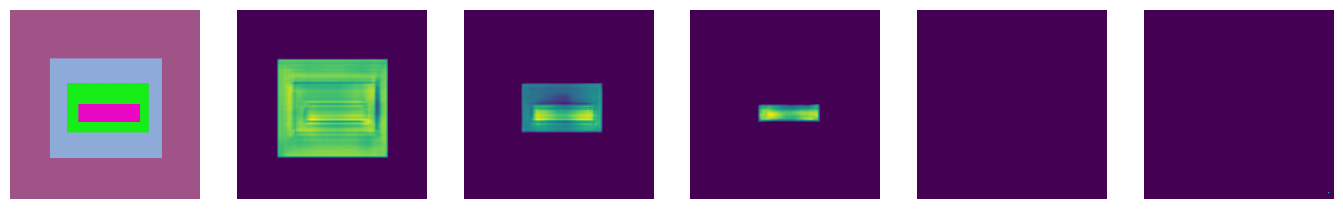

In [35]:
model.resetState()
show_results(model, dRP500.val, 2)

### Exp -  RP500, CNN-GRU implementation

Meant for one-to-one implementation - not suitable

In [53]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.nn import init
from torch.autograd import Variable


class ConvGRUCell(Model):
    """
    Generate a convolutional GRU cell
    """

    def __init__(self, input_size, hidden_size, kernel_size):
        super().__init__()
        padding = kernel_size // 2
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.reset_gate = nn.Conv2d(input_size + hidden_size, hidden_size, kernel_size, padding=padding)
        self.update_gate = nn.Conv2d(input_size + hidden_size, hidden_size, kernel_size, padding=padding)
        self.out_gate = nn.Conv2d(input_size + hidden_size, hidden_size, kernel_size, padding=padding)

        init.orthogonal_(self.reset_gate.weight)
        init.orthogonal_(self.update_gate.weight)
        init.orthogonal_(self.out_gate.weight)
        init.constant_(self.reset_gate.bias, 0.)
        init.constant_(self.update_gate.bias, 0.)
        init.constant_(self.out_gate.bias, 0.)


    def forward(self, input_, prev_state):

        # get batch and spatial sizes
        batch_size = input_.data.size()[0]
        spatial_size = input_.data.size()[2:]

        # generate empty prev_state, if None is provided
        if prev_state is None:
            state_size = [batch_size, self.hidden_size] + list(spatial_size)
            if torch.cuda.is_available():
                prev_state = Variable(torch.zeros(state_size)).cuda()
            else:
                prev_state = Variable(torch.zeros(state_size))

        # data size is [batch, channel, height, width]
        stacked_inputs = torch.cat([input_, prev_state], dim=1)
        update = F.sigmoid(self.update_gate(stacked_inputs))
        reset = F.sigmoid(self.reset_gate(stacked_inputs))
        out_inputs = F.tanh(self.out_gate(torch.cat([input_, prev_state * reset], dim=1)))
        new_state = prev_state * (1 - update) + out_inputs * update

        return new_state


class ConvGRU(Model):

    def __init__(self, input_size, hidden_sizes, kernel_sizes, n_layers):
        '''
        Generates a multi-layer convolutional GRU.
        Preserves spatial dimensions across cells, only altering depth.

        Parameters
        ----------
        input_size : integer. depth dimension of input tensors.
        hidden_sizes : integer or list. depth dimensions of hidden state.
            if integer, the same hidden size is used for all cells.
        kernel_sizes : integer or list. sizes of Conv2d gate kernels.
            if integer, the same kernel size is used for all cells.
        n_layers : integer. number of chained `ConvGRUCell`.
        '''

        super(ConvGRU, self).__init__()

        self.input_size = input_size

        if type(hidden_sizes) != list:
            self.hidden_sizes = [hidden_sizes]*n_layers
        else:
            assert len(hidden_sizes) == n_layers, '`hidden_sizes` must have the same length as n_layers'
            self.hidden_sizes = hidden_sizes
        if type(kernel_sizes) != list:
            self.kernel_sizes = [kernel_sizes]*n_layers
        else:
            assert len(kernel_sizes) == n_layers, '`kernel_sizes` must have the same length as n_layers'
            self.kernel_sizes = kernel_sizes

        self.n_layers = n_layers

        cells = []
        for i in range(self.n_layers):
            if i == 0:
                input_dim = self.input_size
            else:
                input_dim = self.hidden_sizes[i-1]

            cell = ConvGRUCell(input_dim, self.hidden_sizes[i], self.kernel_sizes[i])
            name = 'ConvGRUCell_' + str(i).zfill(2)

            setattr(self, name, cell)
            cells.append(getattr(self, name))

        self.cells = cells


    def forward(self, x, hidden=None):
        '''
        Parameters
        ----------
        x : 4D input tensor. (batch, channels, height, width).
        hidden : list of 4D hidden state representations. (batch, channels, height, width).

        Returns
        -------
        upd_hidden : 5D hidden representation. (layer, batch, channels, height, width).
        '''
        if not hidden:
            hidden = [None]*self.n_layers

        input_ = x

        upd_hidden = []

        for layer_idx in range(self.n_layers):
            cell = self.cells[layer_idx]
            cell_hidden = hidden[layer_idx]

            # pass through layer
            upd_cell_hidden = cell(input_, cell_hidden)
            upd_hidden.append(upd_cell_hidden)
            # update input_ to the last updated hidden layer for next pass
            input_ = upd_cell_hidden

        # retain tensors in list to allow different hidden sizes
        return upd_hidden

In [67]:
model = ConvGRU(3, 
                hidden_sizes=[32,64,16,1],
                kernel_sizes=[3, 5, 3], 
                n_layers=3).to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(4.).cuda())
writer = SummaryWriter(f"./runs/RP500_CNNGRU", comment="BCE=4.0,lr=1e-4,cells=3")
n_params(model)

321

In [79]:
n_epochs = (0, 10)
dataset = dRP500
device = 'cuda'
for epoch in range(*n_epochs):
    epoch_loss = 0
    for data in dataset.train:        
        image, annotation = data
        image = image.to(device).unsqueeze(dim=0)
        
        optimizer.zero_grad()
        
        output = model(image)
        
        l = 0
    
        for weight, ann in enumerate(annotation):
            ann = torch.tensor(ann).to("cuda").unsqueeze(dim=0).unsqueeze(dim=0)
            l += loss(output[-1], ann)
            # next step input                
            output = model(image)
        
        l.backward()
        
        optimizer.step()
    
        epoch_loss += float(l)
        
    epoch_loss /= len(dataset.train)
    writer.add_scalar("Loss/train", epoch_loss, epoch)
    print(f"Epoch {epoch}: {epoch_loss}")
        
    # val
    with torch.inference_mode():
        val_loss = 0
        for data in dataset.val:
            
            image, annotation = data
            image = image.to(device).unsqueeze(dim=0)
            
            output = model(image)
            
            l = 0
        
            for weight, ann in enumerate(annotation):
                ann = torch.tensor(ann).to("cuda").unsqueeze(dim=0).unsqueeze(dim=0)
                l += loss(output[-1], ann)
                # next step input                
                output = model(image)
                
            val_loss += float(l)
            
        val_loss /= len(dataset.val)
        writer.add_scalar("Loss/val", val_loss, epoch)
        writer.add_scalar("GradNorm", model.grad_norm(), epoch)
        
if False:
    for i, thresh in enumerate(np.arange(0, 1, 0.1)):
        writer.add_scalar("Dice/train", dice_score(model, dataset.train, thresh), i)
        writer.add_scalar("Dice/val", dice_score(model, dataset.val, thresh), i)

Epoch 0: 3.133318409173952
Epoch 1: 3.085067173441447
Epoch 2: 3.063026823169803
Epoch 3: 3.05093120703727
Epoch 4: 3.0434626041270265
Epoch 5: 3.0384654665361843
Epoch 6: 3.0349227859601844
Epoch 7: 3.032299765622825
Epoch 8: 3.0302911689486147
Epoch 9: 3.028711493329313


In [80]:
len(annotation)

4

## PP500

### Exp - PP500, R-CNN

In [17]:
s = 300
model = RCNNCell(3, s, s).to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(4.).cuda())
writer = SummaryWriter(f"./runs2/PP500_RCNN", comment="BCE_pos=4.0, lr=1e-4")
n_params(model)

898

In [18]:
train(dPP500,
      model,
      optimizer,
      loss,
      writer,
      n_epochs=(0, 100),
      norm=255.0,
      dice=True)

Epoch 0: 3.4902613842487336
Epoch 1: 3.3760644420981407
Epoch 2: 3.340224481523037
Epoch 3: 3.30009995251894
Epoch 4: 3.2554948979616167
Epoch 5: 3.208793303370476
Epoch 6: 3.1685689842700957
Epoch 7: 3.1169861197471618
Epoch 8: 3.058181755244732
Epoch 9: 2.984433844387531
Epoch 10: 2.9389232835173607
Epoch 11: 2.911149138212204
Epoch 12: 2.8919707426428793
Epoch 13: 2.872326821684837
Epoch 14: 2.8631587675213814
Epoch 15: 2.8497218537330626
Epoch 16: 2.8405189135670663
Epoch 17: 2.8316940551996233
Epoch 18: 2.821249322593212
Epoch 19: 2.813274001479149
Epoch 20: 2.8060809636116026
Epoch 21: 2.8014418479800223
Epoch 22: 2.7957993599772455
Epoch 23: 2.788779889345169
Epoch 24: 2.786444447040558
Epoch 25: 2.781012409031391
Epoch 26: 2.780635802745819
Epoch 27: 2.7761413338780403
Epoch 28: 2.7725338232517243
Epoch 29: 2.766963076591492
Epoch 30: 2.7641548338532447
Epoch 31: 2.7609789395332336
Epoch 32: 2.75856703042984
Epoch 33: 2.756867928802967
Epoch 34: 2.754167752563953
Epoch 35: 2.75

In [22]:
torch.save(model, "./models/PP500_RCNN_1.pth")

In [21]:
get_iou(model, dPP500)

T    IoU     , IoU     , DICE    , DICE    
0.00: 89.324125, 92.752916, 0.786196, 0.800368
0.10: 89.251589, 92.703519, 0.821368, 0.833966
0.20: 88.944380, 92.701949, 0.854440, 0.872239
0.30: 88.502923, 91.651923, 0.880220, 0.888945
0.40: 87.711322, 90.020658, 0.885084, 0.884670
0.50: 86.998224, 89.835625, 0.888591, 0.889153
0.60: 86.080340, 89.629745, 0.890956, 0.896814
0.70: 85.462512, 89.359500, 0.897068, 0.898786
0.80: 84.476634, 87.235893, 0.895369, 0.889775
0.90: 83.414868, 86.859683, 0.893626, 0.891331
1.00: 82.045584, 85.522610, 0.888834, 0.888060


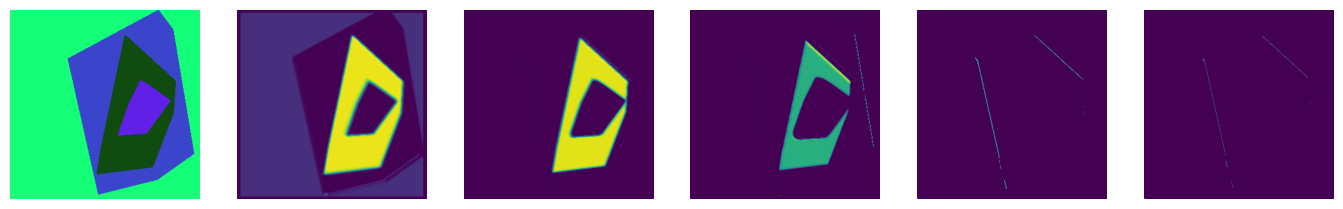

In [20]:
show_results(model, dPP500.val, 4, height=300, width=300)

### Exp - PP500, LSTM Cell

In [23]:
model = RLSTMCell(3, 300, 300).to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(4.).cuda())
writer = SummaryWriter(f"./runs2/PP500_RLSTM", comment="Lr_1e-5, BCE=4., deeper")
n_params(model)

2096

In [24]:
train(dPP500,
      model,
      optimizer,
      loss,
      writer,
      n_epochs=(0,100),
      norm=255.0,
      dice=True)

Epoch 0: 3.3292527556419373
Epoch 1: 3.1418491807579993
Epoch 2: 3.046060289144516
Epoch 3: 2.9497673377394675
Epoch 4: 2.8964342376589776
Epoch 5: 2.842243882417679
Epoch 6: 2.799489080309868
Epoch 7: 2.7700766935944556
Epoch 8: 2.7482490757107736
Epoch 9: 2.7274814930558207
Epoch 10: 2.7087273079156877
Epoch 11: 2.6926440888643266
Epoch 12: 2.6783641716837883
Epoch 13: 2.664862924218178
Epoch 14: 2.6471828046441077
Epoch 15: 2.6321656608581545
Epoch 16: 2.616906156539917
Epoch 17: 2.6079853147268297
Epoch 18: 2.5945900228619574
Epoch 19: 2.578865948021412
Epoch 20: 2.5589496234059332
Epoch 21: 2.546778080761433
Epoch 22: 2.5316187795996665
Epoch 23: 2.5144263151288033
Epoch 24: 2.499012793600559
Epoch 25: 2.4864328157901765
Epoch 26: 2.477358040213585
Epoch 27: 2.464279279112816
Epoch 28: 2.446496153175831
Epoch 29: 2.4339601895213128
Epoch 30: 2.4224887028336526
Epoch 31: 2.408289160132408
Epoch 32: 2.401522011458874
Epoch 33: 2.386297393143177
Epoch 34: 2.379106204509735
Epoch 35: 

In [28]:
get_iou(model, dPP500)

T    IoU     , IoU     , DICE    , DICE    
0.00: 89.904389, 87.515711, 0.843365, 0.803011
0.10: 91.310555, 88.003273, 0.834889, 0.796728
0.20: 91.262217, 89.075110, 0.823544, 0.788842
0.30: 90.819722, 88.533105, 0.803570, 0.778096
0.40: 90.680400, 86.418463, 0.792681, 0.756523
0.50: 90.094701, 83.913343, 0.785319, 0.731928
0.60: 88.270157, 85.093588, 0.772711, 0.724271
0.70: 86.142159, 83.470154, 0.750986, 0.712130
0.80: 81.289771, 81.681031, 0.711759, 0.678838
0.90: 72.392927, 75.649418, 0.649043, 0.641985
1.00: 0.290065, 0.295858, 0.290065, 0.295858


In [30]:
torch.save(model, "./models/dPP500_LSTM.pth")

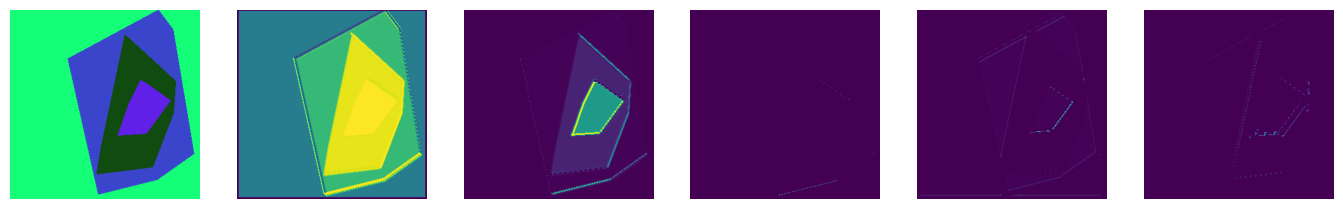

In [32]:
model.resetState()
show_results(model, dPP500.val, 4, height=300, width=300)

### Exp - PP500 RSegNet

In [35]:
model = RCNNCell(3, 300, 300, UnitProcess=SegNet).to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(4.).cuda())
writer = SummaryWriter(f"./runs2/PP500_RCNN_SegNet", comment="BCE_pos=4.0, segnet, lr=1e-4, dropout")
n_params(model)

935911

In [37]:
train(dPP500,
      model,
      optimizer,
      loss,
      writer,
      n_epochs=(0,50),
      norm=255,
      dice=True)

Epoch 0: 2.7059847262501715
Epoch 1: 2.5060285061597822
Epoch 2: 2.399820505976677
Epoch 3: 2.3691713041067124
Epoch 4: 2.3372093456983567
Epoch 5: 2.3411233681440353
Epoch 6: 2.3028791683912275
Epoch 7: 2.2711514857411386
Epoch 8: 2.2417130672931673
Epoch 9: 2.2398562282323837
Epoch 10: 2.252176080644131
Epoch 11: 2.2472535535693168
Epoch 12: 2.2462447065114977
Epoch 13: 2.2144159188866617
Epoch 14: 2.206994613111019
Epoch 15: 2.2080936375260354
Epoch 16: 2.183635281920433
Epoch 17: 2.2044442933797836
Epoch 18: 2.186123612225056
Epoch 19: 2.1767516478896143
Epoch 20: 2.238113217353821
Epoch 21: 2.1786721566319467
Epoch 22: 2.1546072494983672
Epoch 23: 2.171655319929123
Epoch 24: 2.1554408416152
Epoch 25: 2.1568051743507386
Epoch 26: 2.168446034193039
Epoch 27: 2.1978819078207015
Epoch 28: 2.1768730199337005
Epoch 29: 2.138898856639862
Epoch 30: 2.128733411133289
Epoch 31: 2.1439457923173904
Epoch 32: 2.141868667900562
Epoch 33: 2.142342683672905
Epoch 34: 2.140795443356037
Epoch 35: 2

In [38]:
torch.save(model, "./models/PP500_RSegNet_1.pth")
# model = torch.load("./models/PP500_RSegNet_1.pth")

In [41]:
get_iou(model, dPP500, norm=255)

T    IoU     , IoU     , DICE    , DICE    
0.00: 0.787048, 0.661133, 0.805433, 0.656145
0.10: 0.800981, 0.668590, 0.817342, 0.699188
0.20: 0.807634, 0.723337, 0.829648, 0.717594
0.30: 0.817543, 0.735619, 0.845517, 0.753671
0.40: 0.836863, 0.724808, 0.856035, 0.776857
0.50: 0.843077, 0.772704, 0.869383, 0.783100
0.60: 0.854271, 0.791344, 0.878503, 0.806976
0.70: 0.862266, 0.792827, 0.878446, 0.808132
0.80: 0.861627, 0.798398, 0.884554, 0.831806
0.90: 0.872036, 0.799953, 0.889115, 0.832137
1.00: 0.877897, 0.817899, 0.893126, 0.827025


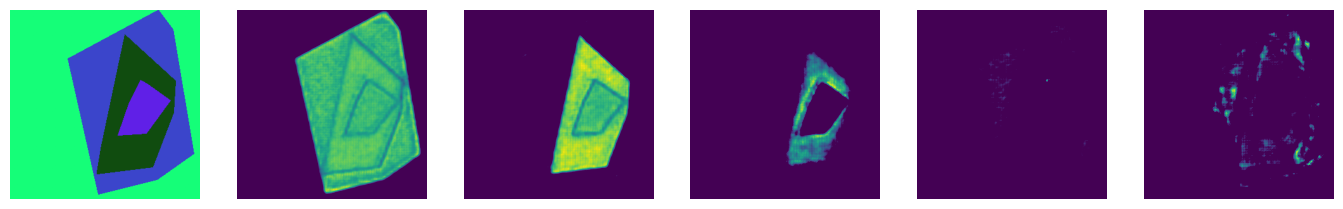

In [40]:
model.resetState()
show_results(model, dPP500.val, 4, height=300, width=300)

### Exp - PP500 LSTMSegNet

In [42]:
model = RLSTMCell(3, 300, 300, cell_unit=SegNet).to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(4.).cuda())
writer = SummaryWriter(f"./runs2/PP500_LSMT_SegNet", comment="BCE_pos=4.0, segnet, lr=1e-4, dropout")
n_params(model)

2492680

In [44]:
train(dPP500,
      model,
      optimizer,
      loss,
      writer,
      n_epochs=(0,30),
      norm=255,
      )

Epoch 0: 2.1195566323399544
Epoch 1: 1.9699804681539534
Epoch 2: 1.9268377205729486
Epoch 3: 1.8706801097095012
Epoch 4: 1.8608060666918755
Epoch 5: 1.8490326642990111
Epoch 6: 1.8040195356309414
Epoch 7: 1.8455900678038597
Epoch 8: 1.830481683909893
Epoch 9: 1.7826526309549808
Epoch 10: 1.791784012913704
Epoch 11: 1.7570246745646
Epoch 12: 1.7400738288462163
Epoch 13: 1.7337409321963788
Epoch 14: 1.742705953270197
Epoch 15: 1.7220476752519607
Epoch 16: 1.7507427513599396
Epoch 17: 1.7013422225415706
Epoch 18: 1.6850019063055515
Epoch 19: 1.6849867804348468
Epoch 20: 1.681230042874813
Epoch 21: 1.6829446846246718
Epoch 22: 1.6795010022819041
Epoch 23: 1.6818351705372334
Epoch 24: 1.676969763636589
Epoch 25: 1.6564441069960594
Epoch 26: 1.65381024569273
Epoch 27: 1.6537311853468417
Epoch 28: 1.690408212542534
Epoch 29: 1.6713524042069912


In [45]:
torch.save(model, "./models/PP500_LSMTSegNet_1.pth")
# model = torch.load("./models/PP500_RSegNet_1.pth")

In [47]:
get_iou(model, dPP500, norm=255)

T    IoU     , IoU     , DICE    , DICE    


0.00: 0.597760, 0.530822, 0.634764, 0.569710
0.10: 0.598264, 0.531073, 0.635248, 0.569261
0.20: 0.599242, 0.530885, 0.635742, 0.569768
0.30: 0.599978, 0.531087, 0.635812, 0.568757
0.40: 0.600366, 0.531002, 0.636150, 0.569294
0.50: 0.601335, 0.530789, 0.636508, 0.568891
0.60: 0.601856, 0.531631, 0.636604, 0.569204
0.70: 0.602545, 0.531371, 0.636599, 0.568083
0.80: 0.602911, 0.531461, 0.636765, 0.567257
0.90: 0.602716, 0.530492, 0.635666, 0.567989
1.00: 0.290065, 0.295858, 0.290065, 0.295858


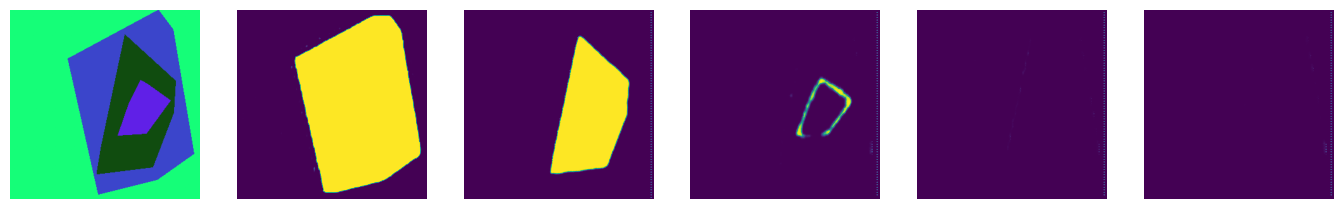

In [46]:
model.resetState()
show_results(model, dPP500.val, 4, height=300, width=300)

## PT500

### Exp - PT500, R-CNN

In [37]:
s = 300
model = RCNNCell(3, s, s).to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(4.).cuda())
writer = SummaryWriter(f"./runs/PT500/RCNN_3", comment="BCE_pos=4.0, lr=1e-4")
n_params(model)

898

In [44]:
train(dPT500,
      model,
      optimizer,
      loss,
      writer,
      n_epochs=(50, 100),
      norm=255.0,
      dice=True)

Epoch 50: 3.1837304911017417
Epoch 51: 3.1772268256545066
Epoch 52: 3.1707983288168906
Epoch 53: 3.164471945166588
Epoch 54: 3.15825259745121
Epoch 55: 3.152134940624237
Epoch 56: 3.146115275025368
Epoch 57: 3.1402064630389215
Epoch 58: 3.134446985423565
Epoch 59: 3.1288716074824334
Epoch 60: 3.1235117533802987
Epoch 61: 3.11838525980711
Epoch 62: 3.11347290456295
Epoch 63: 3.108766714632511
Epoch 64: 3.1042641714215278
Epoch 65: 3.099941756725311
Epoch 66: 3.095785317718983
Epoch 67: 3.0917925772070887
Epoch 68: 3.08795721501112
Epoch 69: 3.084269931316376
Epoch 70: 3.080720166563988
Epoch 71: 3.0773017171025274
Epoch 72: 3.07400450527668
Epoch 73: 3.070828802883625
Epoch 74: 3.0677699115872383
Epoch 75: 3.064824041426182
Epoch 76: 3.0619843566417693
Epoch 77: 3.059242401123047
Epoch 78: 3.0565954259037973
Epoch 79: 3.0540391564369203
Epoch 80: 3.051568896472454
Epoch 81: 3.0491821122169496
Epoch 82: 3.046875616014004
Epoch 83: 3.044643726348877
Epoch 84: 3.0424842685461044
Epoch 85: 

In [51]:
torch.save(model, "./models/PT500_RCNN.pth")

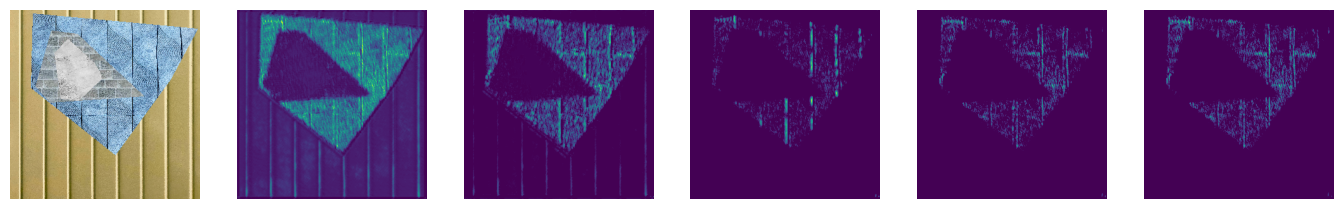

In [52]:
show_results(model, dPT500.train, 9, height=300, width=300)

### Exp - PP500, LSTM Cell

In [54]:
model = RLSTMCell(3, 300, 300).to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(4.).cuda())
writer = SummaryWriter(f"./runs/PT500/RLSSTM_1", comment="Lr_1e-5, BCE=4., deeper")
n_params(model)

2096

In [59]:
train(dPT500,
      model,
      optimizer,
      loss,
      writer,
      n_epochs=(50, 100),
      norm=255.0,
      dice=True)

Epoch 50: 2.8587397590279577
Epoch 51: 2.8501771649718286
Epoch 52: 2.841994569003582
Epoch 53: 2.8341695019602775
Epoch 54: 2.826665398180485
Epoch 55: 2.8194695514440538
Epoch 56: 2.812559878230095
Epoch 57: 2.805938414931297
Epoch 58: 2.799574399292469
Epoch 59: 2.793454708755016
Epoch 60: 2.787577259838581
Epoch 61: 2.781889522075653
Epoch 62: 2.776412681043148
Epoch 63: 2.77113352060318
Epoch 64: 2.766021667420864
Epoch 65: 2.7610774558782576
Epoch 66: 2.756299029290676
Epoch 67: 2.751660968363285
Epoch 68: 2.7471831142902374
Epoch 69: 2.7428300726413726
Epoch 70: 2.73861592233181
Epoch 71: 2.734505071043968
Epoch 72: 2.7305082246661185
Epoch 73: 2.7266362071037293
Epoch 74: 2.722839656472206
Epoch 75: 2.719130402803421
Epoch 76: 2.715527680516243
Epoch 77: 2.7120337560772896
Epoch 78: 2.708609945178032
Epoch 79: 2.7053086447715757
Epoch 80: 2.7021006512641907
Epoch 81: 2.6990031415224074
Epoch 82: 2.6959986591339113
Epoch 83: 2.693084448873997
Epoch 84: 2.690259602367878
Epoch 85

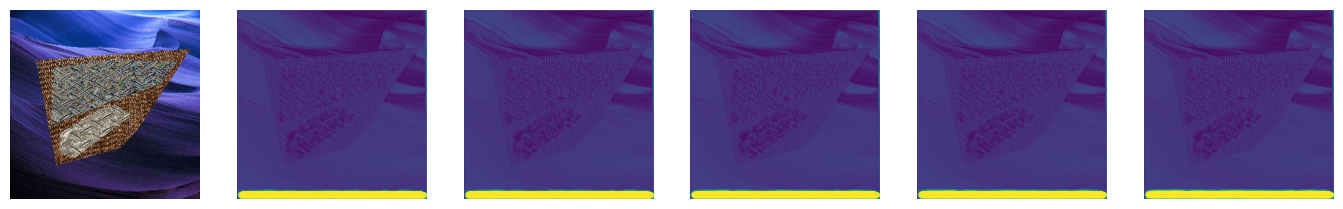

In [58]:
show_results(model, dPT500.val, 2, height=300, width=300)

### Exp - PP500 RSegNet

In [82]:
model = RCNNCell(3, 300, 300, UnitProcess=SegNet).to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(4.).cuda())
writer = SummaryWriter(f"./runs/PT500/RCNN_SegNet_4", comment="BCE_pos=4.0, segnet, lr=1e-3, dropout")
n_params(model)

935911

In [83]:
train(dPP500,
      model,
      optimizer,
      loss,
      writer,
      n_epochs=(0, 100),
      norm=255,
      dice=True)

Epoch 0: 3.1007561868429185
Epoch 1: 2.7696888780593873
Epoch 2: 2.589514386355877
Epoch 3: 2.4096501046419143
Epoch 4: 2.3558916103839875
Epoch 5: 2.3191884541511536
Epoch 6: 2.315128252506256
Epoch 7: 2.2722485771775247
Epoch 8: 2.25347796946764
Epoch 9: 2.233461767435074
Epoch 10: 2.224080443382263
Epoch 11: 2.2035147324204445
Epoch 12: 2.1964833810925484
Epoch 13: 2.174962713420391
Epoch 14: 2.164126745164394
Epoch 15: 2.157160005569458
Epoch 16: 2.150963739156723
Epoch 17: 2.1463175961375236
Epoch 18: 2.1419125732779505
Epoch 19: 2.1342688941955568
Epoch 20: 2.1834886845946313
Epoch 21: 2.1547594064474107
Epoch 22: 2.134073631167412
Epoch 23: 2.1243872380256654
Epoch 24: 2.1206286737322806
Epoch 25: 2.118721292614937
Epoch 26: 2.116506572663784
Epoch 27: 2.1099543249607087
Epoch 28: 2.1039884254336356
Epoch 29: 2.101725390255451
Epoch 30: 2.1029073256254196
Epoch 31: 2.098706728219986
Epoch 32: 2.1021584871411325
Epoch 33: 2.1223415318131447
Epoch 34: 2.107331516444683
Epoch 35: 2

In [105]:
# torch.save(model, "./models/PT500_RSegNet")
model = torch.load("./models/PT500_RSegNet")

In [113]:
get_iou(model, dPT500, norm=255)

0.00: 135.803582, 126.802791
0.10: 135.759276, 126.644150
0.20: 135.815040, 126.729381
0.30: 135.776485, 126.780925
0.40: 135.785205, 126.561680
0.50: 135.817513, 126.812382
0.60: 135.723821, 126.721715
0.70: 135.868385, 126.606480
0.80: 135.741929, 126.648263
0.90: 135.761571, 126.624955


PT does learn a little about PP too

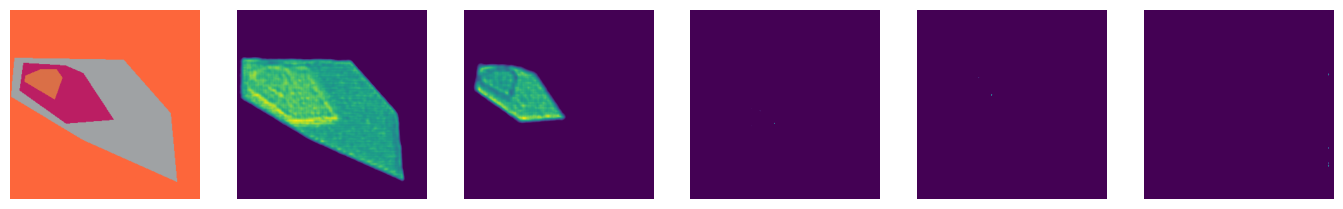

In [117]:
show_results(model, dPP500.val, 1, height=300, width=300)